# Machine Problem 1 - Affine Transformations
### Submitted by: Darius Vincent Ardales | DIGIMAP - S13

# Dependencies

In [41]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import requests

# For reproducibility
np.random.seed(42)

# Data Preparation

### Helper Functions

In [42]:
# Function to fetch images from a public GitHub repository folder
def fetch_images(base_url, image_names):
    images = []
    
    for image_name in image_names:
        raw_url = f'{base_url}/{image_name}'
        response = requests.get(raw_url)

        if response.status_code == 200:
            image_data = np.frombuffer(response.content, np.uint8)
            img = cv.imdecode(image_data, cv.IMREAD_COLOR)
            img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

            images.append(img_rgb)
        else:
            print(f"Failed to download {image_name}")
    
    return images

In [43]:
# Function to read all images from a directory and store them in a list
def read_images_from_dir(dir_path):
    images = []
    
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img = cv.imread(file_path)
            img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            
            images.append(img_rgb)
    
    return images

In [44]:
# Function to take an image list and displays them
def display_images(images, columns=5):
    rows = (len(images) + columns - 1) // columns

    plt.figure(figsize=(15, rows * 3))
    
    for i, img in enumerate(images):
        plt.subplot(rows, columns, i + 1)
        plt.imshow(img)
    
    plt.tight_layout()
    plt.show()

### Loading the Data

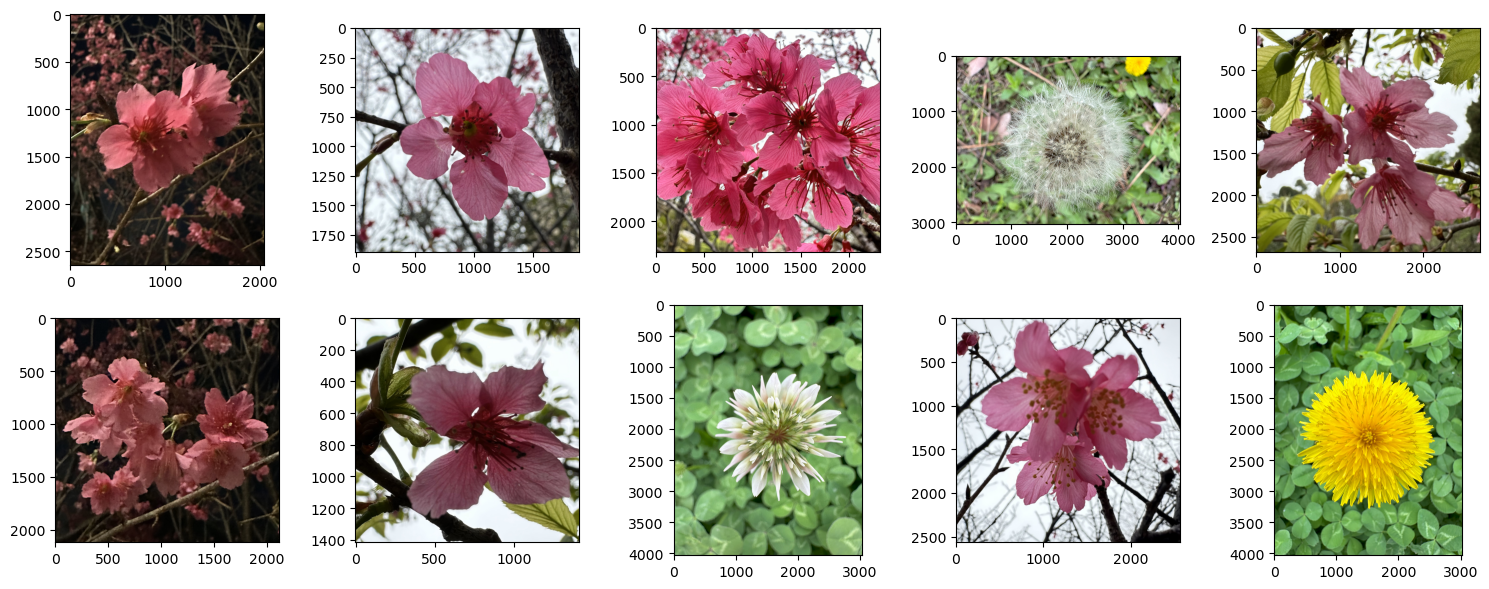

In [45]:
base_url = "https://raw.githubusercontent.com/dyjdlopez/fund-dip/main/media/dataset2"
image_names = [
    '0001.jpg', '0002.jpg', '0003.jpg', '0007.jpg', '0008.jpg',
    '0009.jpg', '0010.jpg', '0011.jpg', '0020.jpg', '0030.jpg'
]

images = fetch_images(base_url, image_names)
display_images(images)

# Data Formatting

Given the image dataset:
- Reshape the images to (100,100,3)
- Save the transformed images as JPEG files in a separate directory.

In [46]:
# Function to resize all images in a list to a given size
def resize_and_save_images(images, output_dir, size=(100, 100)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, img in enumerate(images):
        # Resize the image to the specified size (100x100 by default)
        # Uses cv2.INTER_LINEAR interpolation by default
        resized_img = cv.resize(img, size)

        output_path = os.path.join(output_dir, f'resized_{i}.jpg')
        
        # Convert back to BGR before saving
        img_bgr = cv.cvtColor(resized_img, cv.COLOR_RGB2BGR)

        # Save the image as a JPEG file
        cv.imwrite(output_path, img_bgr)  

    print(f"All images have been resized and saved to {output_dir}")

In [47]:
# Check the shapes of the images
for image in images:
  print(image.shape)

(2648, 2045, 3)
(1892, 1892, 3)
(2317, 2317, 3)
(3024, 4032, 3)
(2679, 2679, 3)
(2113, 2113, 3)
(1414, 1414, 3)
(4032, 3024, 3)
(2559, 2559, 3)
(4032, 3024, 3)


In [48]:
# Reshape the images to (100,100,3) and save them in a separate directory
output_dir = "resized_images"

resize_and_save_images(images, output_dir)

All images have been resized and saved to resized_images


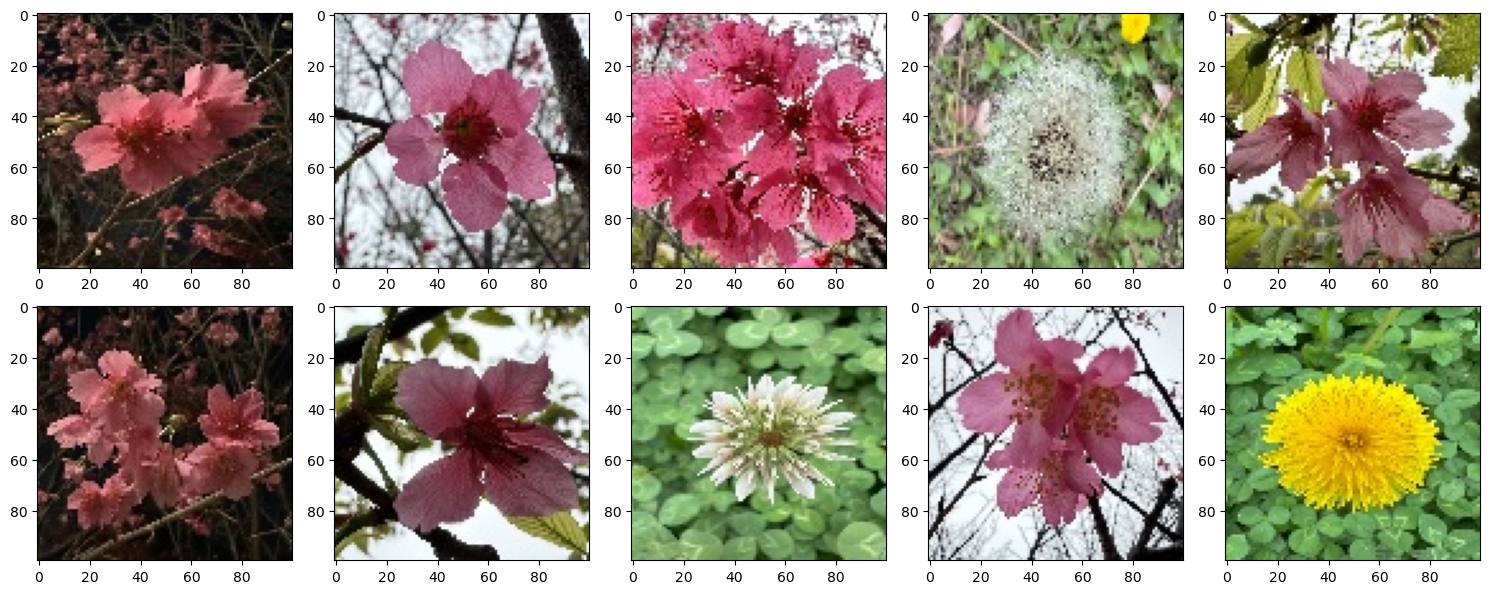

In [49]:
# Display the resized images
resized_images = read_images_from_dir(output_dir)
display_images(resized_images)

In [50]:
# Check the shapes of the resized images
for image in resized_images:
  print(image.shape)

(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)


# Data Augmentation

Create individual parametrized functions that can:
- Randomly put a black patch over a portion of the image.
- Shift an image sideward or upwards.
- Rotate an image.
- Flip an image either vertically or horizontally.

Produce a new augmented dataset with at least 100 images (original images included) using the functions made in the previous action item.

### Randomly putting a black patch over a portion of an image

In [51]:
# Function to randomly place a black patch over a portion of the image
def random_black_patch(img, patch_size=(30, 30)):
    img_copy = img.copy()
    rows, cols, _ = img_copy.shape
    
    x = np.random.randint(0, cols - patch_size[1])
    y = np.random.randint(0, rows - patch_size[0])

    # Setting the value to 0 makes it black
    img_copy[y:y + patch_size[0], x:x + patch_size[1]] = 0  
    return img_copy

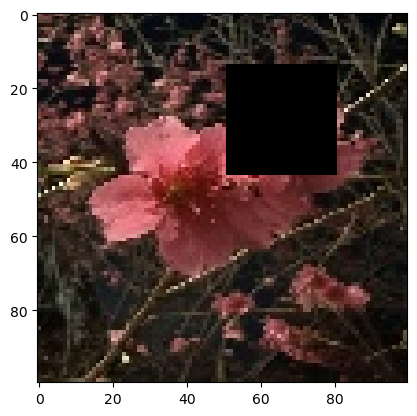

In [52]:
# Test the random_black_patch function
test = random_black_patch(resized_images[0])
plt.imshow(test)

### Shifting an image sideward or upwards

In [53]:
# Function to shift an image either sideward or upward
def shift_image(img, x=0, y=0):
    img_copy = img.copy()
    rows, cols, ch = img_copy.shape
    
    M = np.float32([[1, 0, x], [0, 1, y]])
    shifted_img = cv.warpAffine(img_copy, M, (cols, rows))
    return shifted_img

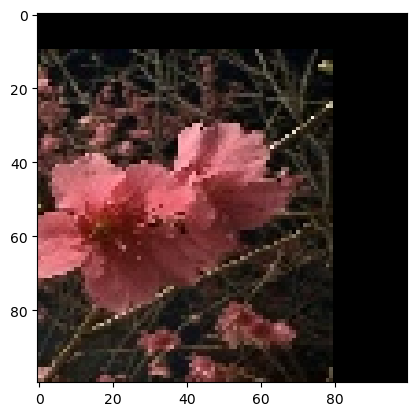

In [54]:
# Test the shift_image function
test = shift_image(resized_images[0], -20, 10)
plt.imshow(test)

### Rotating an image

In [55]:
def rotate_image(img, theta=30, scale=1.0, center=None):
    img_copy = img.copy()
    rows, cols, ch = img_copy.shape
    
    # If no center is provided, use the geometric center of the image
    if center is None:
        center = ((cols - 1) / 2.0, (rows - 1) / 2.0)
    
    M = cv.getRotationMatrix2D(center, theta, scale)
    rotated_img = cv.warpAffine(img_copy, M, (cols, rows))
    
    return rotated_img

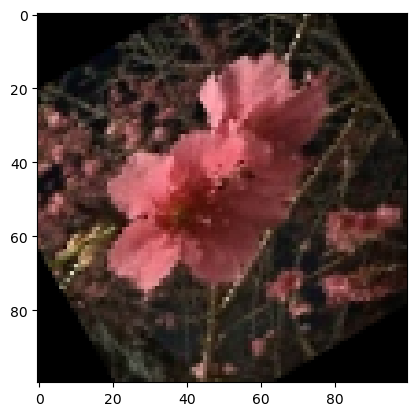

In [56]:
# Test the rotate_image function
test = rotate_image(resized_images[0])
plt.imshow(test)

### Flipping an image either vertically or horizontally

In [57]:
# Function to flip an image vertically or horizontally
def flip_image(img, flip_code=1):
    img_copy = img.copy()
    
    # flip_code: 1 = horizontal, 0 = vertical, -1 = both
    flipped_img = cv.flip(img_copy, flip_code)
    return flipped_img

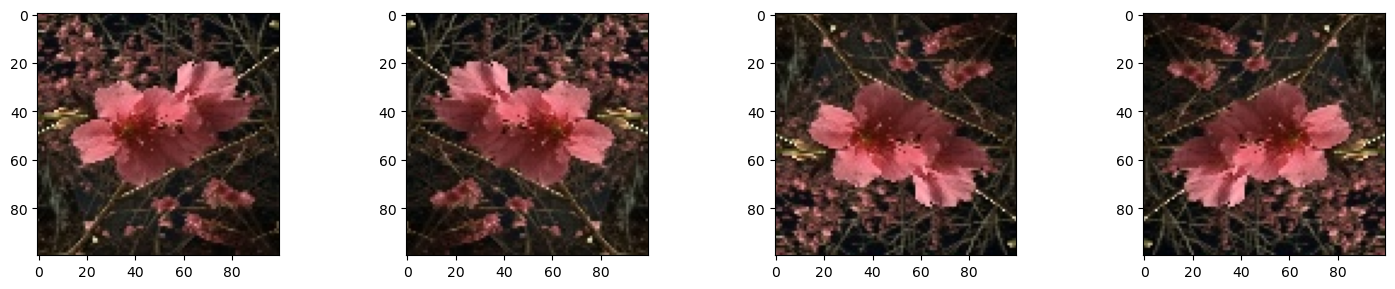

In [58]:
# Test the flip_image function
flipped_images = [
    resized_images[0],             # Original
    cv.flip(resized_images[0], 1),   # Horizontal flip
    cv.flip(resized_images[0], 0),   # Vertical flip
    cv.flip(resized_images[0], -1)   # Both axes flip
]

display_images(flipped_images, 4)

### Producing a new augmented dataset with at least 100 images (original images included) using the functions made

In [59]:
# Function to apply augmentations and save augmented images
def augment_and_save_images(images, output_dir, augment_count=100):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    total_images = len(images)
    images_needed = augment_count - total_images

    augmented_images = []
    
    # Save the original images
    for idx, img in enumerate(images):
        # Save the original image
        img_name = f'original_{idx}.jpg'
        cv.imwrite(os.path.join(output_dir, img_name), cv.cvtColor(img, cv.COLOR_RGB2BGR))
        augmented_images.append(img)
    
    i = 0
    while len(augmented_images) < augment_count:
        # Randomly select an image from the original set
        img = images[np.random.randint(0, total_images)]

        # Keep track of whether any augmentation was applied
        augmentation_applied = False

        # Randomly apply transformations
        if np.random.choice([True, False]):
            img = random_black_patch(img, patch_size=(np.random.randint(25, 75), np.random.randint(25, 75)))
            augmentation_applied = True
        
        if np.random.choice([True, False]):
            img = shift_image(img, x=np.random.randint(-50, 50), y=np.random.randint(-50, 50))
            augmentation_applied = True
        
        if np.random.choice([True, False]):
            img = rotate_image(img, theta=np.random.randint(-75, 75), scale=1.0)
            augmentation_applied = True
        
        if np.random.choice([True, False]):
            img = flip_image(img, flip_code=np.random.choice([0, 1, -1]))
            augmentation_applied = True

        # If no augmentations were applied, randomly choose one augmentation to apply
        if not augmentation_applied:
            augmentation_functions = [
                lambda img: random_black_patch(img, patch_size=(np.random.randint(25, 75), np.random.randint(25, 75))),
                lambda img: shift_image(img, x=np.random.randint(-50, 50), y=np.random.randint(-50, 50)),
                lambda img: rotate_image(img, theta=np.random.randint(-75, 75), scale=1.0),
                lambda img: flip_image(img, flip_code=np.random.choice([0, 1, -1]))
            ]
            img = np.random.choice(augmentation_functions)(img)

        # Save the augmented image
        img_name = f'augmented_{i}.jpg'
        cv.imwrite(os.path.join(output_dir, img_name), cv.cvtColor(img, cv.COLOR_RGB2BGR))
        augmented_images.append(img)
        i += 1
    
    print(f"Created {len(augmented_images)} images and saved them to {output_dir}")
    
    return augmented_images

In [60]:
# Apply to the original (resized) images
augmented_dir = 'augmented_images'

augmented_images = augment_and_save_images(resized_images, augmented_dir, augment_count=100)

Created 100 images and saved them to augmented_images


# Guide Questions

### 1. Define Data Augmentation and discuss its importance and the importance of understanding digital image processing for such an activity.

> According to AWS, data augmentation is a process to artificially generate new data from existing data. This is especially useful for image datasets, given the number of image recognition models being developed today. By augmenting images, a model can be trained to generalize better, enabling it to recognize images even when they've been altered through shifts, rotations, or flips. Essentially, data augmentation helps models become more robust when encountering unseen data. By presenting varied versions of the same images, overfitting can be reduced.

> One major challenge in image-based tasks is the collection of large datasets. Instead of collecting new data, we can maximize what we already have by performing data augmentation. Since models interpret images as numerical data, augmented images are just as valuable for training as newly collected ones. Furthermore, the importance of data augmentation becomes clear when addressing the problem of class imbalance. Having built several models, including those for object detection, I’ve personally experienced the struggles of working with imbalanced datasets. With data augmentation, we can create a more balanced dataset, improving the model's ability to learn from all classes equally.

> In relation to this, understanding digital image processing is crucial for effective data augmentation. It involves manipulating images using algorithms to perform operations like filtering, transformation, enhancement, and restoration. This understanding gives us control over image quality. Without it, applying transformations can lead to unintended distortions, which can harm model performance. Additionally, knowing image processing allows us to create augmentation pipelines that are both computationally efficient and effective in enriching the dataset. From our lessons, I’ve realized that different types of images (e.g., grayscale, RGB) require specific processing techniques. By understanding digital image processing, we ensure that transformations are applied correctly for each image type.

### 2. What other data augmentation techniques are applicable and not applicable to the dataset you have produced? Why?

#### Applicable:
- Adjusting the Brightness or Contrast:
  - In the real world, images are captured under varying lighting conditions such as whether it’s a cloudy day, indoor lighting, or a bright sunny afternoon. Adjusting brightness or contrast simulates these natural variations, making the dataset more reflective of the diverse environments in which images might be taken.

- Zooming / Cropping (Scaling):
  - In everyday life, objects may appear larger or smaller depending on their distance from the camera or observer. Zooming in or out simulates this real-world variation in perspective, making the dataset more diverse in terms of how objects are framed.

- Noise Injection (Gaussian Noise)
  - In real-world scenarios, images can often be imperfect due to environmental factors like low lighting, poor camera sensors, or image compression during sharing. Adding Gaussian noise to the dataset mimics these imperfections, making the data more realistic.

- Color Jittering
  - Colors in the real world vary due to changes in lighting, time of day, and surrounding elements. For example, an object can appear in different shades or hues under natural sunlight, artificial light, or in the shade. By introducing color jittering, the dataset reflects the real-world scenarios where objects’ colors might shift subtly.

- Affine Transformations (Warps)
  - In the real world, objects are often viewed from different angles or under slight distortions due to camera positions or movement. For example, a picture taken from the side or slightly above will appear sheared or rotated compared to one taken head-on. Affine transformations (like rotation and shearing) help simulate these natural perspective shifts without distorting the essential structure of the object.


#### Not Applicable:
- Severe Geometric Distortions
  - While minor geometric adjustments can simulate natural shifts in perspective, severe distortions such as extreme warping or shearing don’t often occur in real-life photography or human perception.

- Translations Beyond Image Boundaries
  - When you shift your focus or move the camera, objects don’t simply disappear from view; they’re often framed with intention or centered within the field of vision.

- Color Space Conversions (e.g., Grayscale to RGB or Vice Versa)
  - Converting an image from grayscale to RGB or vice versa doesn’t add any new meaningful data or represent any real-world condition. Grayscale images are often used when color is irrelevant, like in security footage or x-rays, while RGB is used to capture full-color scenes. Artificially converting between these modes doesn’t simulate any real environmental condition or help capture how things naturally appear in everyday life.

- Gamma Correction Beyond Realistic Values
  - While gamma correction can simulate changes in exposure or lighting, using extreme gamma values can create images that are either too bright or too dark to be useful. In most real-world scenarios, objects are not viewed in extremely high or low exposure environments.

##### References:
 - [A survey on Image Data Augmentation for Deep Learning](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0)
 - [Image Data Augmentation Approaches: A Comprehensive Survey and Future directions](https://arxiv.org/abs/2301.02830)